In [2]:
import pandas as pd
import requests
import datetime
import numpy as np
from flowprintOptimal.sekigo.core.flowRepresentation import FlowRepresentation
from flowprintOptimal.sekigo.flowUtils.commons import loadFlows, saveFlows
from flowprintOptimal.sekigo.flowUtils.sampler import FixedLengthSampler, FixedLengthSimpleSampler
from typing import List, Dict,Tuple
from joblib import Parallel, delayed
from tqdm import tqdm
import json
from flowprintOptimal.sekigo.core.featureExtractor import FeatureExtractor
from flowprintOptimal.sekigo.dataAnalysis.vNATDataFrameProcessor import VNATDataFrameProcessor
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from flowprintOptimal.sekigo.core.flowConfig import FlowConfig
import math
from flowprintOptimal.sekigo.flowUtils.commons import getValidInvalidStartingPointsForSubFlowStart
import random

In [3]:
#flow_config = FlowConfig(grain = 1,band_thresholds= [625,1250])
flow_config = FlowConfig(grain= .5,band_thresholds= [1250])

In [4]:
flows = VNATDataFrameProcessor.convertToFlowRepresentations(data_frame_path= "data/VNAT/vnat_dataframe.h5",flow_config= flow_config)
saveFlows(path= "data/VNAT/flowStore/vnatflowshalfsecond_2_bands.json", flows= flows)

100%|██████████| 33711/33711 [09:52<00:00, 56.86it/s]  


In [4]:
flows = loadFlows(path= "/Users/rushi/Desktop/UNSW/data/VNAT/flowStore/vnatflows1second.json")

In [5]:
flows = VNATDataFrameProcessor.convertLabelsToTopLevel(flows)

In [6]:
len(flows)

33094

In [8]:
def trainAndTestRandomForest(data,required_length_in_seconds,random_sample):
    f1 = 0
    experiments = 10
    for _ in range(experiments):
        if random_sample == True:
            split_flows = FixedLengthSimpleSampler.sampleAndCutToLength(data= data,flow_config= data[0].flow_config,required_length_in_seconds= required_length_in_seconds,min_activity_for_start_point= required_length_in_seconds)
            flows = split_flows["train_flows"] + split_flows["test_flows"]
            X = FeatureExtractor.extractFeaturesFromFlowList(flows)
            y = list(map(lambda x : x.class_type,flows))
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        else:
            split_flows = FixedLengthSampler.sampleAndCutToLength(data= data,flow_config= data[0].flow_config,required_length_in_seconds= required_length_in_seconds,ratio_of_median_to_sample= .05, min_activity_for_start_point= required_length_in_seconds, sample_wise_train_ratio = .7, temporal_train_ratio= .7)
            X_train = FeatureExtractor.extractFeaturesFromFlowList(split_flows["train_flows"])
            y_train = list(map(lambda x : x.class_type,split_flows["train_flows"]))
            X_test = FeatureExtractor.extractFeaturesFromFlowList(split_flows["test_flows"])
            y_test = list(map(lambda x : x.class_type,split_flows["test_flows"]))


        X_train = np.array(X_train)
        y_train = np.array(y_train)

    
        #print(pd.Series(y_train).value_counts())
        #print(pd.Series(y_test).value_counts())


        rf = RandomForestClassifier(max_depth= 5)
        rf.fit(X_train,y_train)
        preds = rf.predict(X_test)
        _,_,f1_,_ = precision_recall_fscore_support(y_test, preds, average= "weighted",labels=rf.classes_)
        f1 += f1_
    return f1/experiments

In [12]:
time = [5,10,15,20,25,30,35,40,45]
f1s = []

for t in tqdm(time):
    f1s.append(trainAndTestRandomForest(data= flows,required_length_in_seconds= t,random_sample= False))

  0%|          | 0/9 [00:00<?, ?it/s]

{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 1811
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 1702
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 1826
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 1688
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 1660
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 1822
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.257183266339139

 11%|█         | 1/9 [04:12<33:39, 252.47s/it]

{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 2713
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 2784
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 2728
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 2806
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 2644
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 2634
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.257183266339139

 22%|██▏       | 2/9 [09:09<32:31, 278.84s/it]

{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3001
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3006
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3170
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3199
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3066
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3196
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.257183266339139

 33%|███▎      | 3/9 [14:26<29:37, 296.17s/it]

{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3386
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3425
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3379
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3354
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3431
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3447
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.257183266339139

 44%|████▍     | 4/9 [19:52<25:40, 308.02s/it]

{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3501
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3219
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3683
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3396
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3570
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3237
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.257183266339139

 56%|█████▌    | 5/9 [25:31<21:16, 319.14s/it]

{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3653
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3646
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3235
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3323
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3744
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3576
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.257183266339139

 67%|██████▋   | 6/9 [31:12<16:20, 326.70s/it]

{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3650
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3778
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3714
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3553
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3899
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3836
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.257183266339139

 78%|███████▊  | 7/9 [37:03<11:09, 334.65s/it]

{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3454
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3612
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 4150
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3764
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 4089
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3915
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.257183266339139

 89%|████████▉ | 8/9 [42:36<05:34, 334.09s/it]

{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 4466
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 4007
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3850
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 4482
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 4141
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.2571832663391395}
overlapping points = 3790
{'streaming': 0.3104362280425895, 'FT': 0.7374599786552828, 'chat': 0.027691617174413107, 'control': 0.257183266339139

100%|██████████| 9/9 [48:11<00:00, 321.32s/it]


In [13]:
f1s_sample = f1s[:]

In [10]:
f1s_simple = f1s[:]

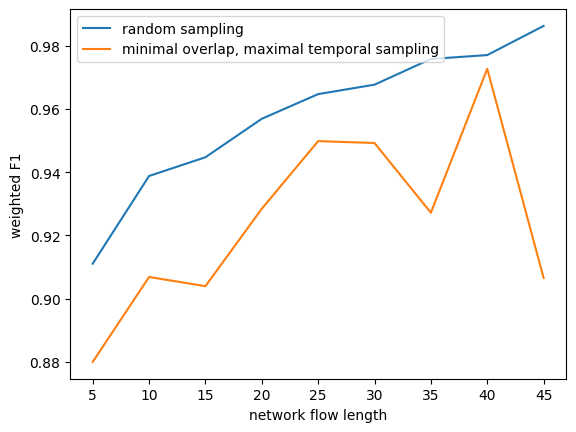

In [15]:
plt.plot(time,f1s_simple, label = "random sampling")
plt.plot(time,f1s_sample, label = "minimal overlap, maximal temporal sampling")
plt.legend(loc="upper left")
plt.ylabel("weighted F1")
plt.xlabel("network flow length")
plt.show()

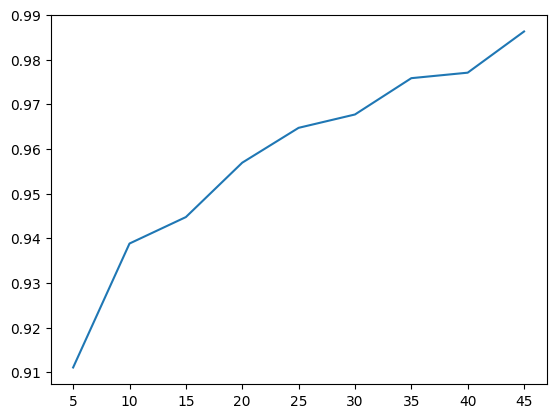

In [11]:
# random sampling of train and test min overlap
plt.plot(time,list(map(lambda x : x, f1s)))

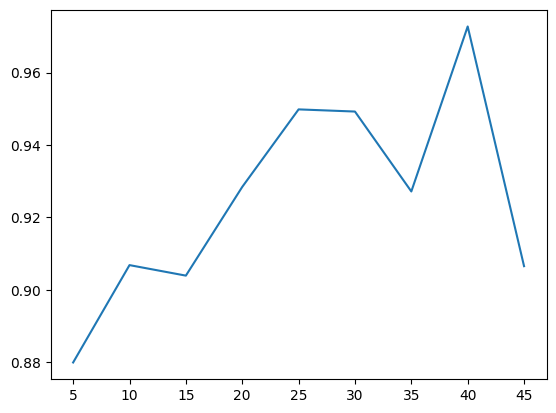

In [14]:
# train and test sampling is different min over lap
plt.plot(time,list(map(lambda x : x, f1s)))

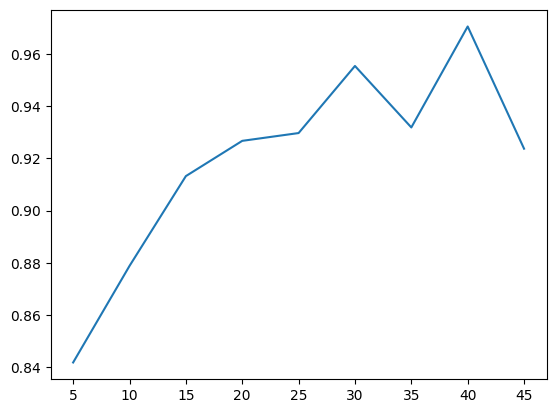

In [7]:
plt.plot(time,list(map(lambda x : x, f1s)))

In [28]:
rf.classes_

array(['FT', 'chat', 'control', 'streaming'], dtype='<U9')

(0.9903165942093276, 0.9901960784313726, 0.9899648865361548, None)

In [30]:
cm = confusion_matrix(y_test, preds, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf.classes_)
disp.plot()
plt.show()

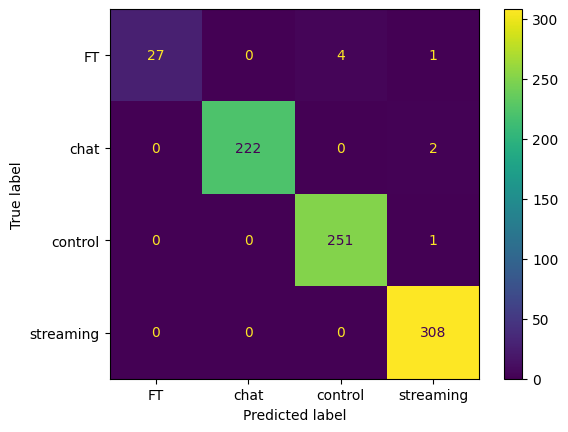